In [156]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("spscientist/students-performance-in-exams")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\lenovo\.cache\kagglehub\datasets\spscientist\students-performance-in-exams\versions\1


In [157]:
import pandas as pd
import os
df = pd.read_csv(os.path.join(path, "StudentsPerformance.csv"))
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [158]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
count,1000,1000,1000,1000,1000,1000.00000,1000.000000,1000.000000
unique,2,5,6,2,2,NaN,NaN,NaN
top,female,group C,some college,standard,none,NaN,NaN,NaN
freq,518,319,226,645,642,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,66.08900,69.169000,68.054000
std,NaN,NaN,NaN,NaN,NaN,15.16308,14.600192,15.195657
min,NaN,NaN,NaN,NaN,NaN,0.00000,17.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,57.00000,59.000000,57.750000
50%,NaN,NaN,NaN,NaN,NaN,66.00000,70.000000,69.000000
75%,NaN,NaN,NaN,NaN,NaN,77.00000,79.000000,79.000000


#### Средние баллы по полу

In [159]:
gender_means = df.groupby('gender')[['math score', 'reading score', 'writing score']].mean()
gender_means

,math score,reading score,writing score
gender,,,
female,63.633205,72.608108,72.467181
male,68.728216,65.473029,63.311203


#### ящик с усами для предварительной проверки гипотезы

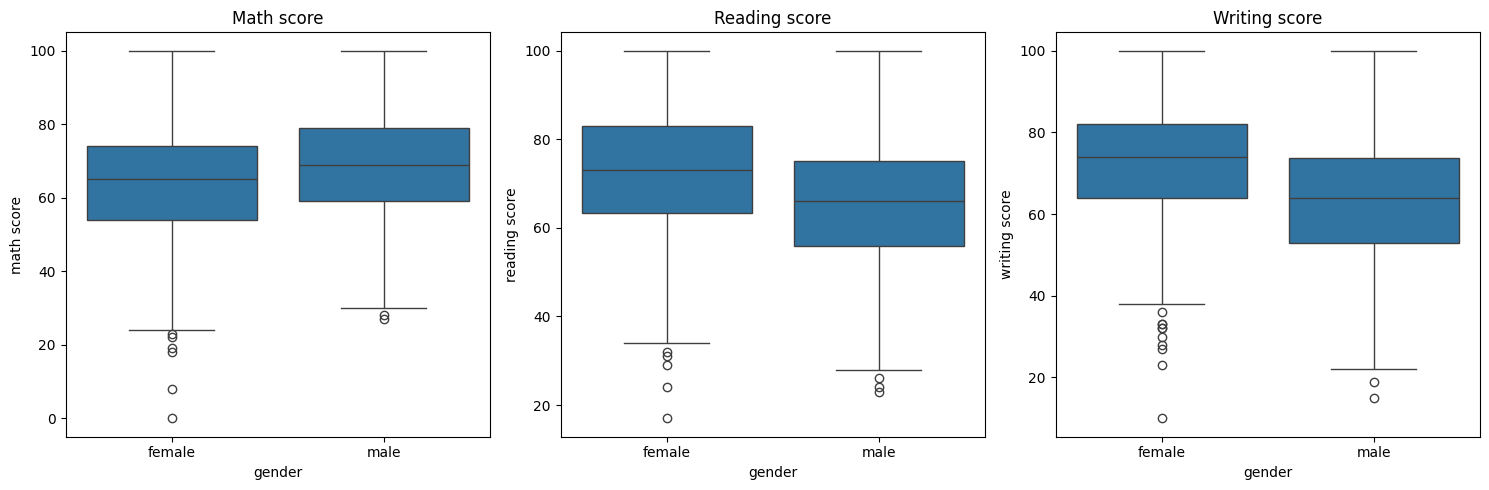

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, subject in enumerate(['math score', 'reading score', 'writing score']):
    sns.boxplot(data=df, x='gender', y=subject, ax=axes[i])
    axes[i].set_title(f'{subject.capitalize()}')
plt.tight_layout()
plt.show()

# Анализ проблем в исходных данных

In [161]:
missing = df.isnull().sum()
print("\nПропуски:")
missing


Пропуски:


gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

## НЕТ ПРОПУСКОВ

In [162]:
duplicates = df.duplicated().sum()
duplicates

np.int64(0)

# НЕТ ДУБЛИКАТОВ

In [163]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print("Уникальные значения в категориальных колонках:")
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Уникальные значения в категориальных колонках:
gender: ['female' 'male']
race/ethnicity: ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch: ['standard' 'free/reduced']
test preparation course: ['none' 'completed']


# ВЫБРОСЫ 
### двумя методами: zcore и IQR

In [164]:
import numpy as np
from scipy import stats


numeric_cols = ['math score', 'reading score', 'writing score']


print("Метод Z-score")
outliers_zcore = {}
for col in numeric_cols:
    z = np.abs(stats.zscore(df[col]))
    outliers_zcore[col] = (z > 3).sum()
print(f"Выбросы (Z-score > 3): {outliers_zcore}")

Метод Z-score
Выбросы (Z-score > 3): {'math score': np.int64(4), 'reading score': np.int64(4), 'writing score': np.int64(4)}


In [165]:
print("Метод IQR")

outliers_iqr = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outliers_iqr[col] = num_outliers
    
    print(f"\n{col}: Q1={Q1:.1f}, Q3={Q3:.1f}, IQR={IQR:.1f} \nграницы [{lower_bound:.1f}, {upper_bound:.1f}] → выбросов: {num_outliers}")

print(f"\nИтого выбросов по IQR: {outliers_iqr}")

Метод IQR

math score: Q1=57.0, Q3=77.0, IQR=20.0 
границы [27.0, 107.0] → выбросов: 8

reading score: Q1=59.0, Q3=79.0, IQR=20.0 
границы [29.0, 109.0] → выбросов: 6

writing score: Q1=57.8, Q3=79.0, IQR=21.2 
границы [25.9, 110.9] → выбросов: 5

Итого выбросов по IQR: {'math score': np.int64(8), 'reading score': np.int64(6), 'writing score': np.int64(5)}


## Анализ показал, что дубликатов и пропусков в данных нет. 
#### Выбросы удалим в следующем блоке 

# Обработка данных

In [166]:
df_clean = df.copy()

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

df_clean = df_clean.reset_index(drop=True)
df_clean.info(), df_clean.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       986 non-null    object
 1   race/ethnicity               986 non-null    object
 2   parental level of education  986 non-null    object
 3   lunch                        986 non-null    object
 4   test preparation course      986 non-null    object
 5   math score                   986 non-null    int64 
 6   reading score                986 non-null    int64 
 7   writing score                986 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 61.8+ KB


(None, (986, 8))

КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

In [ ]:

#OHE
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
print("Кодирование выполнено. Новые колонки:")
print([col for col in df_encoded.columns if col not in ['math score', 'reading score', 'writing score']])

df_encoded



=== КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===
Кодирование выполнено. Новые колонки:
['gender_male', 'race/ethnicity_group B', 'race/ethnicity_group C', 'race/ethnicity_group D', 'race/ethnicity_group E', "parental level of education_bachelor's degree", 'parental level of education_high school', "parental level of education_master's degree", 'parental level of education_some college', 'parental level of education_some high school', 'lunch_standard', 'test preparation course_none']


,math score,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none
0,72,72,74,False,True,False,False,False,True,False,False,False,False,True,True
1,69,90,88,False,False,True,False,False,False,False,False,True,False,True,False
2,90,95,93,False,True,False,False,False,False,False,True,False,False,True,True
3,47,57,44,True,False,False,False,False,False,False,False,False,False,False,True
4,76,78,75,True,False,True,False,False,False,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,88,99,95,False,False,False,False,True,False,False,True,False,False,True,False
982,62,55,55,True,False,True,False,False,False,True,False,False,False,False,True
983,59,71,65,False,False,True,False,False,False,True,False,False,False,False,False
984,68,78,77,False,False,False,True,False,False,False,False,True,False,True,False


In [ ]:
df_encoded['average_score'] = df_encoded[['math score', 'reading score', 'writing score']].mean(axis=1)
df_encoded['total_score'] = df_encoded[['math score', 'reading score', 'writing score']].sum(axis=1)
df_encoded['math_reading_diff'] = df_encoded['math score'] - df_encoded['reading score']
df_encoded['writing_advantage'] = (df_encoded['writing score'] > df_encoded['math score']).astype(int)
df_encoded['high_achiever'] = (df_encoded['average_score'] >= 80).astype(int)  # порог выбран эмпирически

print("новые признаки:")
print(" - average_score: средний балл")
print(" - total_score: суммарный балл")
print(" - math_reading_diff: разница между математикой и чтением")
print(" - writing_advantage: 1 если письмо лучше математики")
print(" - high_achiever: 1 если средний балл >= 80")

df_encoded

новые признаки:
 - average_score: средний балл
 - total_score: суммарный балл
 - math_reading_diff: разница между математикой и чтением
 - writing_advantage: 1 если письмо лучше математики
 - high_achiever: 1 если средний балл ≥ 80


,math score,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none,average_score,total_score,math_reading_diff,writing_advantage,high_achiever
0,72,72,74,False,True,False,False,False,True,False,False,False,False,True,True,72.666667,218,0,1,0
1,69,90,88,False,False,True,False,False,False,False,False,True,False,True,False,82.333333,247,-21,1,1
2,90,95,93,False,True,False,False,False,False,False,True,False,False,True,True,92.666667,278,-5,1,1
3,47,57,44,True,False,False,False,False,False,False,False,False,False,False,True,49.333333,148,-10,0,0
4,76,78,75,True,False,True,False,False,False,False,False,True,False,True,True,76.333333,229,-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,88,99,95,False,False,False,False,True,False,False,True,False,False,True,False,94.000000,282,-11,1,1
982,62,55,55,True,False,True,False,False,False,True,False,False,False,False,True,57.333333,172,7,0,0
983,59,71,65,False,False,True,False,False,False,True,False,False,False,False,False,65.000000,195,-12,1,0
984,68,78,77,False,False,False,True,False,False,False,False,True,False,True,False,74.333333,223,-10,1,0


In [170]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['math score', 'reading score', 'writing score', 
                    'average_score', 'total_score', 'math_reading_diff']

scaler = StandardScaler()
df_encoded_scaled = df_encoded.copy()
df_encoded_scaled[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

df_encoded_scaled

,math score,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none,average_score,total_score,math_reading_diff,writing_advantage,high_achiever
0,0.370131,0.163761,0.371152,False,True,False,False,False,True,False,False,False,False,True,True,0.320493,0.320493,0.337855,1,0
1,0.160831,1.458384,1.342041,False,False,True,False,False,False,False,False,True,False,True,False,1.039082,1.039082,-2.004955,1,1
2,1.625930,1.818002,1.688787,False,True,False,False,False,False,False,True,False,False,True,True,1.807229,1.807229,-0.219957,1,1
3,-1.374034,-0.915092,-1.709324,True,False,False,False,False,False,False,False,False,False,False,True,-1.414033,-1.414033,-0.777768,0,0
4,0.649197,0.595302,0.440501,True,False,True,False,False,False,False,False,True,False,True,True,0.593061,0.593061,0.114730,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,1.486397,2.105696,1.827485,False,False,False,False,True,False,False,True,False,False,True,False,1.906344,1.906344,-0.889331,1,1
982,-0.327535,-1.058939,-0.946483,True,False,True,False,False,False,True,False,False,False,False,True,-0.819338,-0.819338,1.118792,0,0
983,-0.536835,0.091837,-0.252991,False,False,True,False,False,False,True,False,False,False,False,False,-0.249423,-0.249423,-1.000893,1,0
984,0.091065,0.595302,0.579200,False,False,False,True,False,False,False,False,True,False,True,False,0.444387,0.444387,-0.777768,1,0


In [ ]:
df_viz = df.copy()

# категория успеваемости
df_viz['average_score'] = df_viz[['math score', 'reading score', 'writing score']].mean(axis=1)
df_viz['performance_category'] = pd.cut(
    df_viz['average_score'],
    bins=[0, 50, 75, 100],
    labels=['Низкая', 'Средняя', 'Высокая']
)

print("Распределение по категориям успеваемости:")
print(df_viz['performance_category'].value_counts())

df_viz  

Распределение по категориям успеваемости:
performance_category
Средняя    578
Высокая    313
Низкая     109
Name: count, dtype: int64


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average_score,performance_category
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,Средняя
1,female,group C,some college,standard,completed,69,90,88,82.333333,Высокая
2,female,group B,master's degree,standard,none,90,95,93,92.666667,Высокая
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,Низкая
4,male,group C,some college,standard,none,76,78,75,76.333333,Высокая
...,...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95,94.000000,Высокая
996,male,group C,high school,free/reduced,none,62,55,55,57.333333,Средняя
997,female,group C,high school,free/reduced,completed,59,71,65,65.000000,Средняя
998,female,group D,some college,standard,completed,68,78,77,74.333333,Средняя


Описательная статистика по полу:
       math score                          reading score                \
             mean median    std <lambda_0>          mean median    std   
gender                                                                   
female      63.63   65.0  15.49       20.0         72.61   73.0  14.38   
male        68.73   69.0  14.36       20.0         65.47   66.0  13.93   

                  writing score                           
       <lambda_0>          mean median    std <lambda_0>  
gender                                                    
female      19.75         72.47   74.0  14.84      18.00  
male        19.00         63.31   64.0  14.11      20.75  


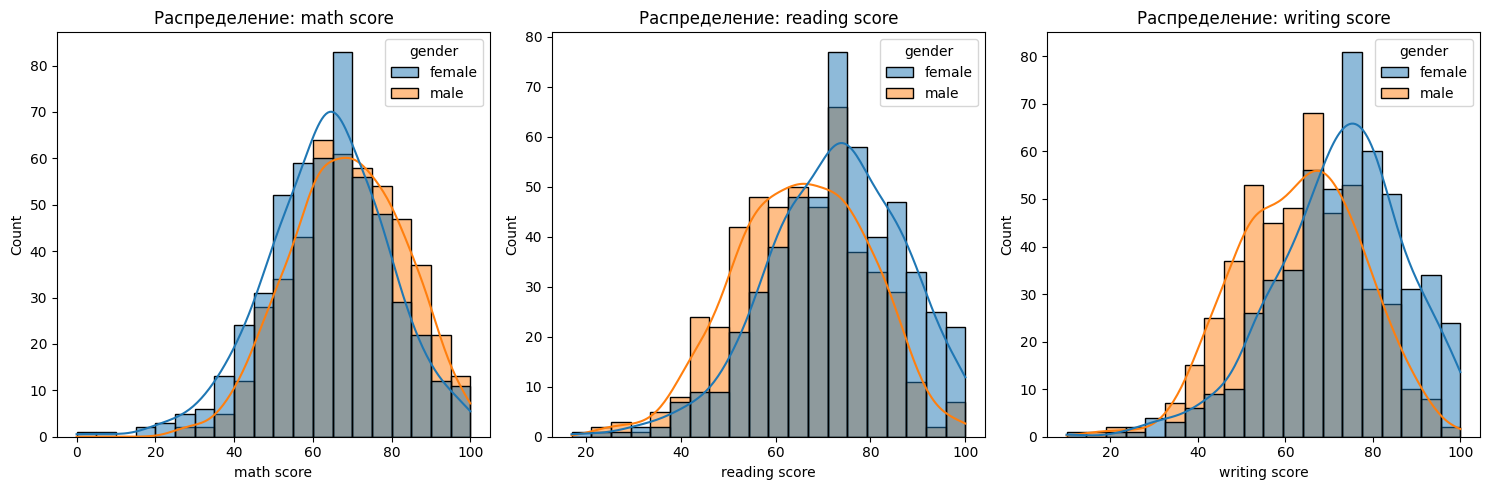

In [ ]:
# Описательная статистика по полу
desc_stats = df_viz.groupby('gender')[['math score', 'reading score', 'writing score']].agg(
    ['mean', 'median', 'std', lambda x: x.quantile(0.75) - x.quantile(0.25)]
).round(2)


print("Описательная статистика по полу:")
print(desc_stats)

# Гистограммы распределения оценок
plt.figure(figsize=(15, 5))
for i, subject in enumerate(['math score', 'reading score', 'writing score'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df_viz, x=subject, hue='gender', kde=True, bins=20)
    plt.title(f'Распределение: {subject}')
plt.tight_layout()
plt.show()

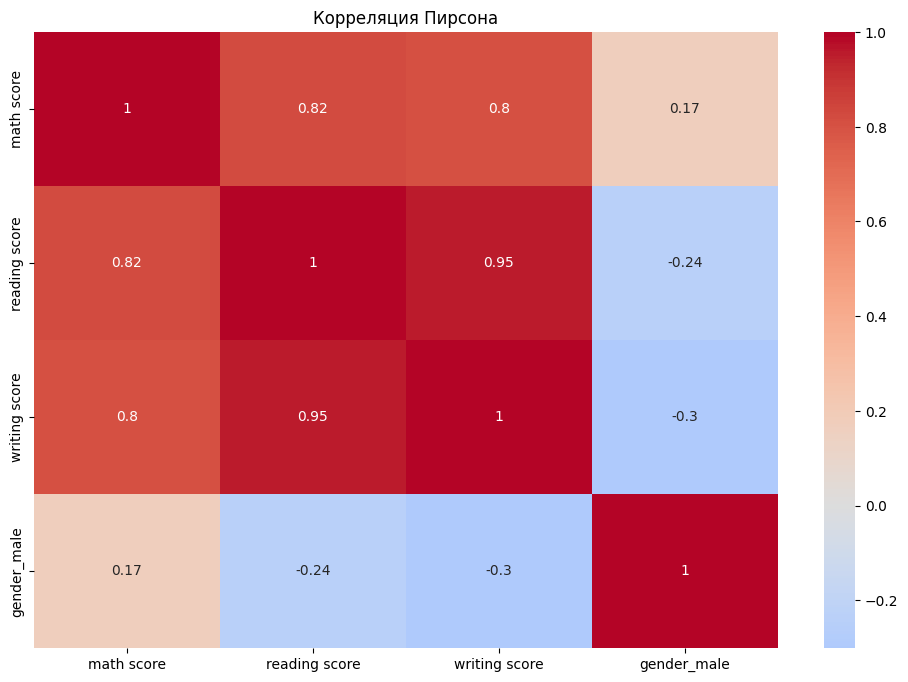

In [ ]:
# Подготовка данных для корреляции (только числовые признаки + закодированный пол)
df_corr = df_viz.copy()
df_corr['gender_male'] = (df_corr['gender'] == 'male').astype(int)  # Кодируем пол

# Корреляция Пирсона
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_corr[['math score', 'reading score', 'writing score', 'gender_male']].corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title('Корреляция Пирсона')
plt.show()

НАГРУЗКИ ФАКТОРОВ
               Factor_1  Factor_2
math score       -0.815    -0.230
reading score    -0.977    -0.011
writing score    -0.972     0.049


C:\Users\lenovo\AppData\Local\Temp\ipykernel_22608\3177511342.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (loadings['Factor_1'][i], loadings['Factor_2'][i]),


(-1.1, 1.1)

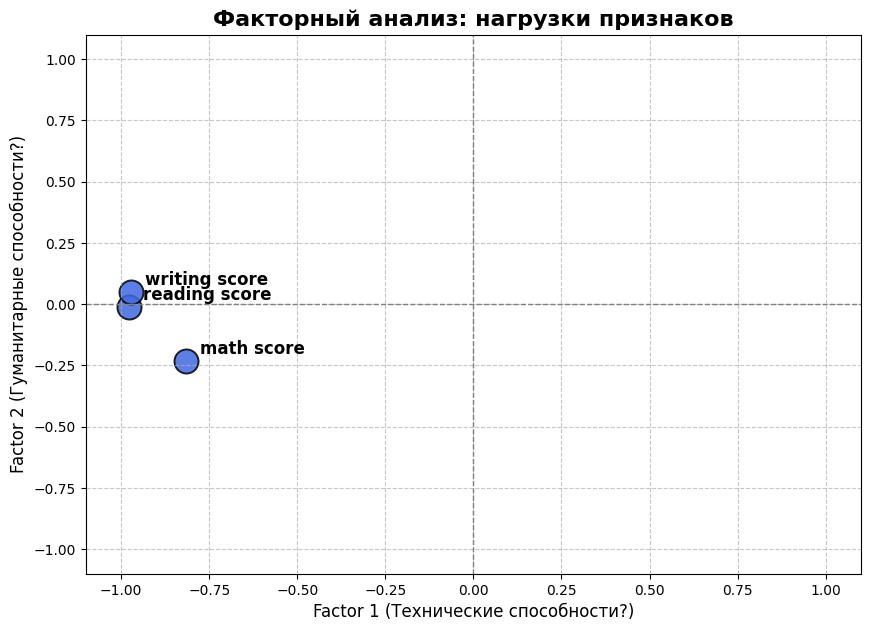

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FactorAnalysis

X_fa = df_encoded_scaled[['math score', 'reading score', 'writing score']].values

fa = FactorAnalysis(n_components=2, random_state=42)
fa.fit(X_fa)

# матрица нагрузок
loadings = pd.DataFrame(
    fa.components_.T,  # Транспонируем для удобства
    columns=['Factor_1', 'Factor_2'],
    index=['math score', 'reading score', 'writing score']
)

print("НАГРУЗКИ ФАКТОРОВ")
print(loadings.round(3))

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    x=loadings['Factor_1'], 
    y=loadings['Factor_2'],
    s=300,
    color='royalblue',
    edgecolor='black',
    alpha=0.85
)

for i, txt in enumerate(loadings.index):
    ax.annotate(
        txt, 
        (loadings['Factor_1'][i], loadings['Factor_2'][i]),
        xytext=(10, 5), 
        textcoords='offset points',
        fontsize=12,
        fontweight='bold'
    )

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Факторный анализ: нагрузки признаков', fontsize=16, fontweight='bold')
plt.xlabel('Factor 1 (Технические способности?)', fontsize=12)
plt.ylabel('Factor 2 (Гуманитарные способности?)', fontsize=12)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)



=== ДИСКРИМИНАНТНЫЙ АНАЛИЗ ===
Точность предсказания пола по баллам: 87.60%

Матрица неточностей:
              Предсказано: male  Предсказано: female
Действит.: male      410          72        
Действит.: female    52           466       


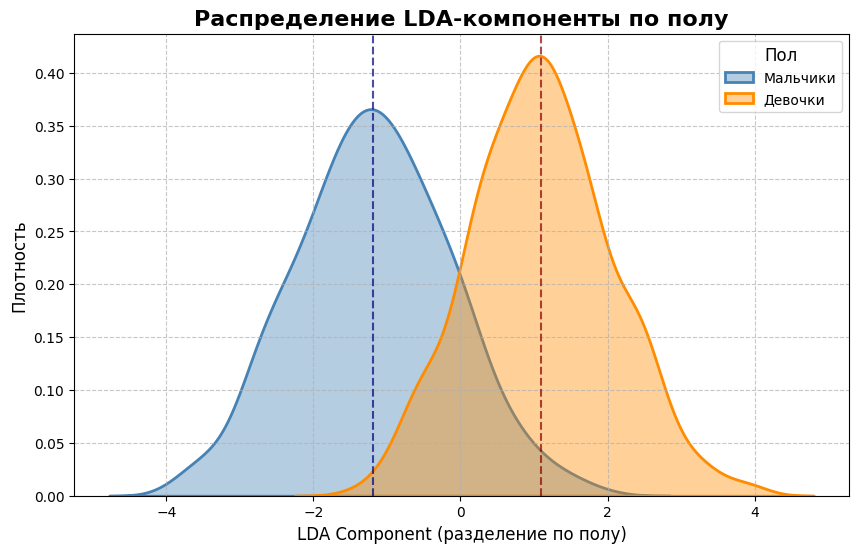

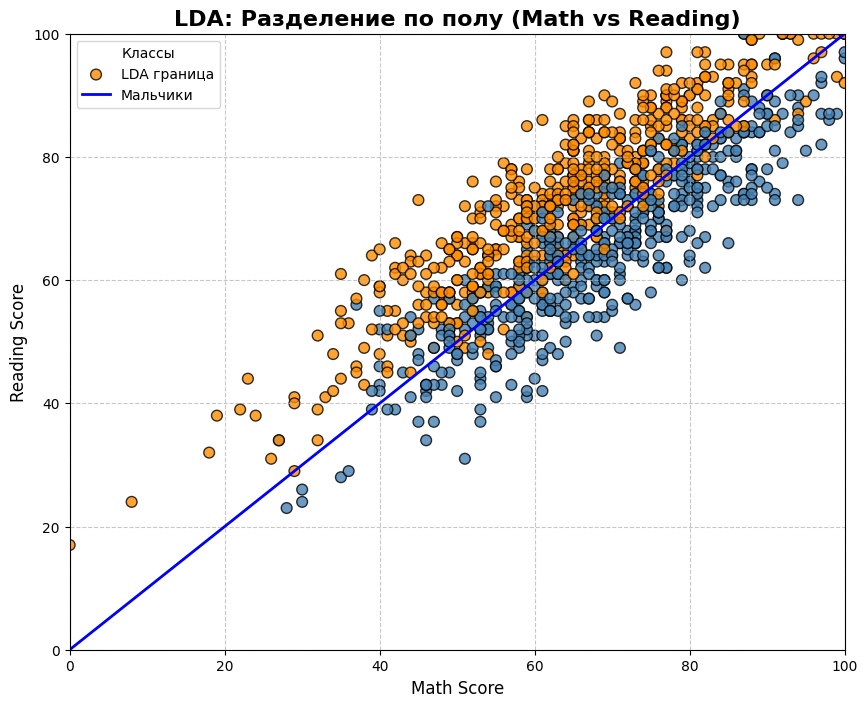

КОЭФФИЦИЕНТЫ LDA
Признак          Вес
math score     : -0.358
reading score  :  0.062
writing score  :  0.321


In [199]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib as mpl

# Используем немастабированные данные для интерпретации
X = df_viz[['math score', 'reading score', 'writing score']].values
y = df_viz['gender'].map({'male': 0, 'female': 1}).values  # male=0, female=1
gender_labels = df_viz['gender'].values

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

y_pred = lda.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"=== ДИСКРИМИНАНТНЫЙ АНАЛИЗ ===")
print(f"Точность предсказания пола по баллам: {accuracy:.2%}")

cm = confusion_matrix(y, y_pred)
print("\nМатрица неточностей:")
print(f"              Предсказано: male  Предсказано: female")
print(f"Действит.: male      {cm[0,0]:<10}   {cm[0,1]:<10}")
print(f"Действит.: female    {cm[1,0]:<10}   {cm[1,1]:<10}")

plt.figure(figsize=(10, 6))

# KDE-плот для каждого пола
sns.kdeplot(
    x=X_lda[y == 0].flatten(), 
    label='Мальчики', 
    fill=True, 
    alpha=0.4, 
    color='steelblue',
    linewidth=2
)
sns.kdeplot(
    x=X_lda[y == 1].flatten(), 
    label='Девочки', 
    fill=True, 
    alpha=0.4, 
    color='darkorange',
    linewidth=2
)

plt.axvline(np.median(X_lda[y == 0]), color='navy', linestyle='--', alpha=0.7)
plt.axvline(np.median(X_lda[y == 1]), color='darkred', linestyle='--', alpha=0.7)

plt.title('Распределение LDA-компоненты по полу', fontsize=16, fontweight='bold')
plt.xlabel('LDA Component (разделение по полу)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(title='Пол', title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


# 2 график
if X.shape[1] >= 2:
    plt.figure(figsize=(10, 8))
    
    scatter = plt.scatter(
        X[:, 0],  # math score
        X[:, 1],  # reading score
        c=y,
        cmap=mpl.colors.ListedColormap(['steelblue', 'darkorange']),
        alpha=0.8,
        s=60,
        edgecolor='k'
    )

    if lda.coef_.shape[1] >= 2 and lda.coef_[0][1] != 0:
        w0, w1 = lda.coef_[0][0], lda.coef_[0][1]
        b = lda.intercept_[0] if lda.intercept_.size > 0 else 0
        
        x_line = np.linspace(0, 100, 100)
        y_line = -(w0 * x_line + b) / w1
        # plt.plot(x_line, y_line, 'k--', linewidth=2, label='LDA граница')
        plt.axline((0, 0), (1, 1), color='blue', linewidth=2, label='y = x')

        plt.legend(['LDA граница', 'Мальчики', 'Девочки'], title='Классы')
    
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    
    plt.title('LDA: Разделение по полу (Math vs Reading)', fontsize=16, fontweight='bold')
    plt.xlabel('Math Score', fontsize=12)
    plt.ylabel('Reading Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Сохраняем
    plt.savefig('lda_boundary.png', dpi=300, bbox_inches='tight')
    plt.show()

print("КОЭФФИЦИЕНТЫ LDA")
print("Признак          Вес")
print(f"math score     : {lda.coef_[0][0]: .3f}")
print(f"reading score  : {lda.coef_[0][1]: .3f}")
print(f"writing score  : {lda.coef_[0][2]: .3f}")
